In [1]:
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, IBMQ, execute

from qiskit.tools.monitor import job_monitor

from qiskit.quantum_info import *

from qiskit.circuit import Parameter

from qiskit.ignis.verification import *

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

from math import pi

import numpy as np

# useful additional packages 
from qiskit.tools.visualization import plot_state_city, plot_bloch_vector
from qiskit.providers.ibmq import least_busy

In [2]:
account = IBMQ.load_account()

In [3]:
theta1 = Parameter('$θ_1$')
phi1 = Parameter('$φ_1$')
lamb1 = Parameter('$λ_1$')

theta2 = Parameter('$θ_2$')
phi2 = Parameter('$φ_2$')
lamb2 = Parameter('$λ_2$')

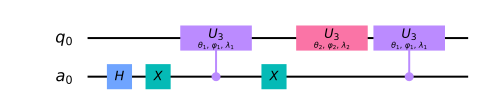

In [4]:
q = QuantumRegister(1, name='q')
a = QuantumRegister(1, name='a')
switch = QuantumCircuit(q, a, name='$\mathcal{S}$')

switch.h(1)
switch.x(1)
switch.cu3(theta1, phi1, lamb1, 1,0)
switch.x(1)
switch.barrier()
switch.u3(theta2, phi2, lamb2, 0)
switch.cu3(theta1, phi1, lamb1, 1,0)

switch.draw(output='mpl', plot_barriers=False, scale=0.6)

In [5]:
#bit-flip and phase-flip channels
instance = switch.bind_parameters({theta1:pi, phi1:0, lamb1:pi, theta2:0, phi2:0, lamb2:pi})

In [6]:
circuits = process_tomography_circuits(instance, [0])

In [7]:
provider = IBMQ.get_provider('ibm-q')
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
j = execute(circuits, backend=backend, shots=8192)
job_monitor(j)

Job Status: job has successfully run


In [8]:
results = j.result()
fitter = ProcessTomographyFitter(results, circuits)
choi = fitter.fit().data

In [9]:
def superoperator(rho, chi):
    return [[rho[0][0]*chi[0][0] + rho[0][1]*chi[0][1] + rho[1][0]*chi[1][0] + rho[1][1]*chi[1][1],
            rho[0][0]*chi[0][2] + rho[0][1]*chi[0][3] + rho[1][0]*chi[1][2] + rho[1][1]*chi[1][3]],
           [rho[0][0]*chi[2][0] + rho[0][1]*chi[2][1] + rho[1][0]*chi[3][0] + rho[1][1]*chi[3][1],
            rho[0][0]*chi[2][2] + rho[0][1]*chi[2][3] + rho[1][0]*chi[3][2] + rho[1][1]*chi[3][3]]]

def T(rho):
    return np.real(np.trace(rho))

In [10]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, 0 - 1.j], [1.j, 0]])
Z = np.array([[1, 0], [0, -1]])

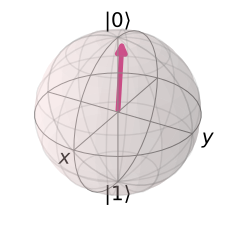

In [11]:
rho = np.array([[0, 0], [0, 1]]) #|1><1|
out = superoperator(rho, choi)

point = [T(X.dot(out)), T(Y.dot(out)), T(Z.dot(out))]
plot_bloch_vector(point, figsize=[3,3])

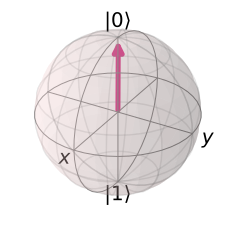

In [12]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1000
j = execute(circuits, shots=shots, backend=backend)
results = j.result()
fitter = ProcessTomographyFitter(results, circuits)
choi = fitter.fit()

out = superoperator(rho, choi)

point = [T(X.dot(out)), T(Y.dot(out)), T(Z.dot(out))]
plot_bloch_vector(point, figsize=[3,3])

In [13]:
print(choi.data)

[[ 0.00568695+0.j         -0.00885716-0.00785316j  0.00897618+0.01349262j
   0.0037193 -0.00074677j]
 [-0.00885716+0.00785316j  0.99532846+0.j         -0.99028504+0.05687121j
  -0.00625956-0.02520239j]
 [ 0.00897618-0.01349262j -0.99028504-0.05687121j  0.99542946+0.j
   0.00345145+0.02117719j]
 [ 0.0037193 +0.00074677j -0.00625956+0.02520239j  0.00345145-0.02117719j
   0.00355513+0.j        ]]
